# Theory and Toy Problems

In [2]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st

# Adding white noise

In [3]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))

In [4]:
def alpha_from_snr(snr):
    return 10**(-snr / 20)

def make_curves(seed, n_samples, dim, snrs, ks):    
    np.random.seed(seed)
    x = np.random.randn(n_samples, dim)
    nx = gs.nearest_neighbors(x)
    curves = []
    for snr in snrs:
        alpha = alpha_from_snr(snr)
        y = x + alpha * (np.random.randn(n_samples, dim))
        ny = gs.nearest_neighbors(y)
        res = []
        for k in ks:
            if k == 0:
                res.append(0)
                continue
            res.append(gs.mean_neighborhood_similarity_from_neighborhood(nx, ny, k))
        curves.append(res)

    return np.array(curves)

In [5]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves)(n, n_samples, dim, snrs, ks)
                                             for n in range(48))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:    3.8s remaining:   56.8s
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:    4.1s remaining:   20.7s
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:    4.2s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:    4.3s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:    4.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:    4.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:    4.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:    4.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    4.5s finished


In [6]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

/home/tiago/miniconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:654: RuntimeWarning: divide by zero encountered in divide
  g2 /= n * N * (M - N) * m * (M - 2.) * (M - 3.)
/home/tiago/miniconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:658: RuntimeWarning: divide by zero encountered in _hypergeom_skewness
  _boost._hypergeom_skewness(n, N, M),


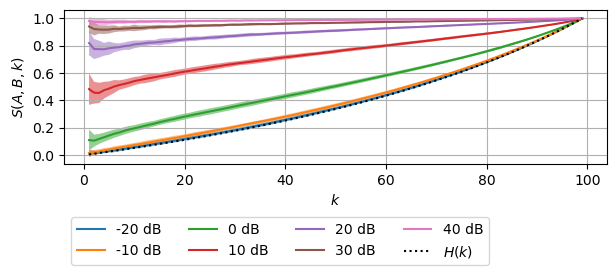

In [7]:

all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='$H(k)$')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_white_noise_100.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3521031/132127426.py:11: RuntimeWarning: invalid value encountered in divide
  yaxis = (np.array(curves[c,:])-np.array(js))/(1-np.array(js))


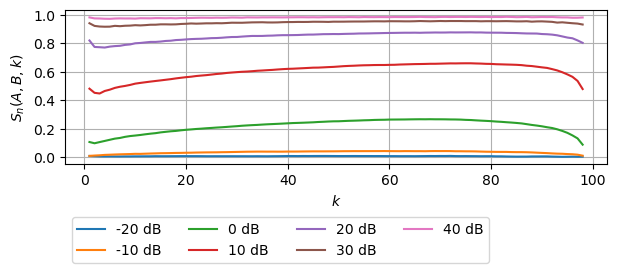

In [8]:

all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    yaxis = (np.array(curves[c,:])-np.array(js))/(1-np.array(js))
    plt.plot(ks, yaxis, label=labels[c])
    #plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

#plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S_n(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))

plt.savefig('sabk_white_noise_100_normalized.pdf', bbox_inches='tight')
plt.show()

# Impact of number of samples

In [9]:
n_samples_list = np.arange(30,200)
dim = 50
k = 0.2
snrs = [-20, -10, 0, 10, 20, 30, 40] 

res = {}
stds = {}
n_repetitions = 10

for snr in tqdm(snrs):
    res[snr] = []
    stds[snr] = []
    alpha = alpha_from_snr(snr)
    for n_samples in n_samples_list:
        this_res = []    
        for _ in range(n_repetitions):            
            A = np.random.randn(n_samples, dim)
            B = A + alpha * np.random.randn(n_samples, dim)
            k_ = int(k * (n_samples-1))
            s = gs.mean_neighborhood_similarity_from_points(A, B, k_)
            this_res.append(s)
        res[snr].append(np.mean(this_res))
        stds[snr].append(np.std(this_res))

100%|██████████| 7/7 [00:42<00:00,  6.08s/it]


In [10]:
print(res)

{-20: [0.10563492063492064, 0.11388074291300096, 0.1112784090909091, 0.12168962350780532, 0.11225490196078432, 0.09871861471861469, 0.11345182595182594, 0.11496062496062498, 0.11465607491923283, 0.11266630805092345, 0.09915617715617717, 0.11011427596793455, 0.11162916448630737, 0.11142578351880679, 0.1187353555535374, 0.10821563621563624, 0.11909737640875744, 0.11291628271603238, 0.10831838504632621, 0.1061343548408374, 0.10428374272786037, 0.1173033988277113, 0.1179341642189939, 0.11443341984261428, 0.1118814419855011, 0.10434296525627791, 0.11509040238902575, 0.11857216139764612, 0.11720412847534653, 0.10840468569229648, 0.11000476681900825, 0.12038076484161726, 0.11314093598141732, 0.109692639277471, 0.1110904455395639, 0.1095886571363756, 0.11611595373629897, 0.11540110289883157, 0.11011546963976623, 0.10959613690237502, 0.10474165552220467, 0.11406864664672382, 0.11875602550964873, 0.11569068458288231, 0.11336192927497275, 0.11094063008381849, 0.12179648621454028, 0.11654573811995

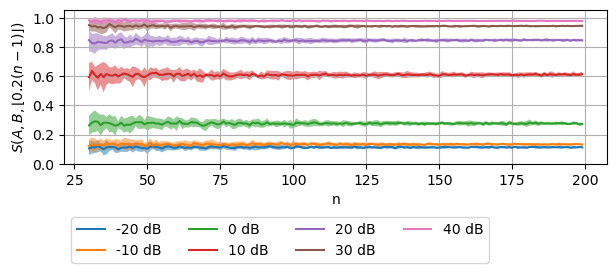

In [11]:

plt.figure(figsize=(7, 2))
labels = [f'{s} dB' for s in snrs]
for idx, snr in enumerate(snrs):
    plt.plot(n_samples_list, res[snr], label=labels[idx])
    plt.fill_between(n_samples_list, np.array(res[snr])+2*np.array(stds[snr]), np.array(res[snr])-2*np.array(stds[snr]), alpha=0.5)

#plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('n')
plt.ylabel(f'$S(A,B,\lfloor {k}(n-1) \\rfloor)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))

plt.savefig('sabk_variation_of_n.pdf', bbox_inches='tight')
plt.show()

# 

# Impact of noise level

In [12]:
n_samples = 100
dim = 50
k = 20
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
snrs = np.linspace(-20, 60, 25)
alphas = np.sqrt(10**(-snrs / 10))
res = []
stds = []
n_repetitions = 10

for alpha in tqdm(alphas):
    this_res = []    
    for _ in range(n_repetitions):
        A = np.random.randn(n_samples, dim)
        B = A + alpha * np.random.randn(n_samples, dim)
        s = gs.mean_neighborhood_similarity_from_points(A, B, k)
        this_res.append(s)
    res.append(np.mean(this_res))
    stds.append(np.std(this_res))

100%|██████████| 25/25 [00:00<00:00, 35.84it/s]


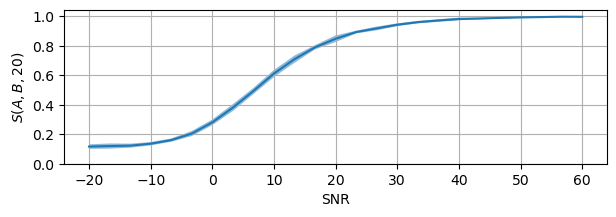

In [13]:
plt.figure(figsize=(7, 2))
snrs = np.array(snrs)
res = np.array(res)
stds = np.array(stds)

plt.plot(snrs, res)
plt.fill_between(snrs, res+np.array(stds)*2, res-np.array(stds)*2, alpha=0.5)
plt.xlabel('SNR')
plt.ylabel(f'$S(A,B,{k})$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
plt.xticks(range(-20, 61, 10))
plt.grid()
plt.savefig('sabk_by_snr.pdf', bbox_inches='tight')
plt.show()

# Impact of dimensions

In [14]:
# argmin_k S(k) and min S(k) do not correlate with dimension (only in <10 dimensions)
snrs = [-20, -10, 0, 10, 20, 30, 40]

dims = list(range(2, 100, 1))
n_samples = 100
k = 20
res = {}
stds = {}
n_repeats = 10
for snr in snrs:
    res[snr] = []
    stds[snr] = []
    for dim in tqdm(dims):
        argm = []
        m = []
        for n in range(n_repeats):
            x = np.random.randn(n_samples, dim)
            A = np.random.randn(n_samples, dim)
            alpha = alpha_from_snr(snr)
            B = A + alpha * np.random.randn(n_samples, dim)
            s = gs.mean_neighborhood_similarity_from_points(A, B, k)
            m.append(s)
        res[snr].append(np.mean(m))
        stds[snr].append(np.std(m))


100%|██████████| 98/98 [00:02<00:00, 33.75it/s]


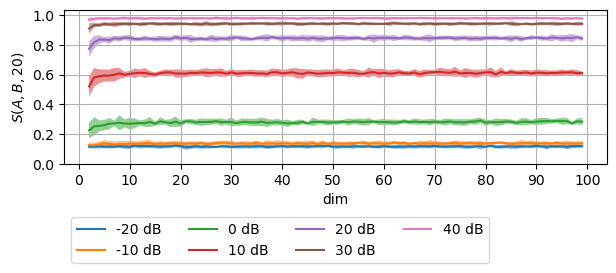

In [15]:
plt.figure(figsize=(7, 2))
for snr in snrs:
    plt.plot(dims, res[snr], label=f'{snr} dB')
    plt.fill_between(dims, res[snr]+np.array(stds[snr])*2, res[snr]-np.array(stds[snr])*2, alpha=0.5)
plt.xlabel('dim')
plt.ylabel(f'$S(A, B, {k})$')
plt.xticks(range(0, 110, 10))
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_dimensions.pdf', bbox_inches='tight')
plt.show()

# Changing the location of clusters

In [16]:
c = 5
n_clusters = 7
dim = 50
samples_per_cluster = 50
np.random.seed(67)
clusters = np.random.randn(n_clusters, dim) * c
clusters2 = np.random.randn(n_clusters, dim) * c

n_samples = samples_per_cluster * clusters.shape[0]
snrs = [-20, -10, 0, 10, 20, 30, 40]


In [17]:
def make_curves_clusters(seed, samples_per_cluster, clusters, clusters2, dim, snrs, ks):    
    n_samples = samples_per_cluster * clusters.shape[0]
    np.random.seed(seed)
    source = np.random.randn(samples_per_cluster, dim)
    x = np.vstack([source + clusters[i,:] for i in range(clusters.shape[0])])
    y = np.vstack([source + clusters2[i,:]  for i in range(clusters.shape[0])])
    nx = gs.nearest_neighbors(x)
    curves = []
    for snr in snrs:
        alpha = alpha_from_snr(snr)
        y = y + alpha * (np.random.randn(n_samples, dim))
        ny = gs.nearest_neighbors(y)
        res = []
        for k in ks:
            if k == 0:
                res.append(0)
                continue
            res.append(gs.mean_neighborhood_similarity_from_neighborhood(nx, ny, k))
        curves.append(res)

    return np.array(curves)

In [18]:

n_clusters = 4
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, samples_per_cluster*clusters.shape[0]-1))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves_clusters)(n, samples_per_cluster, clusters, clusters2, dim, snrs, ks)
                                             for n in range(48))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:  1.3min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:  1.3min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:  1.3min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:  1.3min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:  1.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:  1.3min remaining:   55.8s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:  1.3min remaining:   35.7s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:  1.3min remaining:   20.8s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:  1.3min remaining:    9.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.3min finished


In [19]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
n_samples = samples_per_cluster*clusters.shape[0]

M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

In [20]:
all_curves_ = np.array(all_curves)
mu = all_curves_.mean(axis=0)
mu.shape

(7, 348)

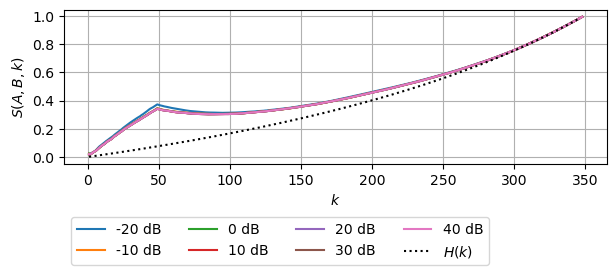

In [21]:
all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2
curves = all_curves_[0,:,:]

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
#    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='$H(k)$')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('clustered_with_whitenoise.pdf', bbox_inches='tight')
plt.show()